In [6]:
from commonfunctions import *
from rle import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
from skimage.transform import resize as sk_resize
from skimage.filters import median, gaussian
from skimage.feature import canny
from skimage.filters import threshold_otsu
from collections import Counter
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate, hough_ellipse, hough_circle, hough_circle_peaks
from skimage import draw
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, closing, opening, square, skeletonize
from skimage.feature import match_template
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

In [8]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [9]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [10]:
def get_gray(img):
    gray = rgb2gray(np.copy(img))
    return gray
def get_thresholded(img, thresh):
    return 1*(img > thresh)

In [11]:
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


In [12]:
def whitene(rle, vals, max_height):
    rlv = []
    for length, value in zip(rle, vals):
        if value == 0 and length < max_height:
            value = 1
        rlv.append((length, value))

    n_rle, n_vals = [], []
    count = 0
    for length, value in rlv:
        if value == 1:
            count = count + length
        else:
            if count > 0:
                n_rle.append(count)
                n_vals.append(1)
            
            count = 0
            n_rle.append(length)
            n_vals.append(0)
    if count > 0:
        n_rle.append(count)
        n_vals.append(1)

    return n_rle, n_vals

def remove_staff_lines(rle, vals, thickness, shape):
    n_rle, n_vals = [], []
    for i in range(len(rle)):
        rl, val = whitene(rle[i], vals[i], 2 * thickness)
        n_rle.append(rl)
        n_vals.append(val)

    return hv_decode(n_rle, n_vals, shape)

1


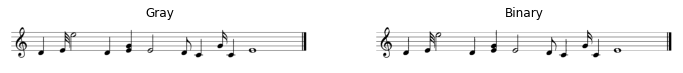

In [13]:
img = io.imread('testcases/test-set-scanned/test-cases/01.PNG')
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
print(np.max(bin_img))
show_images([gray, bin_img], ['Gray', 'Binary'])

In [14]:
rle, vals = hv_rle(bin_img)
most_common = get_most_common(rle)
thickness, spacing = calculate_thickness_spacing(rle, most_common)
thick_space = thickness + spacing
print(most_common, thickness, spacing)

22 2 20


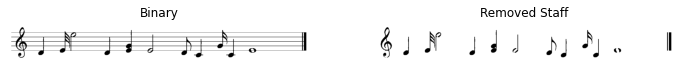

In [15]:
no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
show_images([bin_img, no_staff_img], ['Binary', 'Removed Staff'])

In [16]:
def histogram(img, thresh):
    hist = (np.ones(img.shape) - img).sum(dtype=np.int32, axis=1)
    _max = np.amax(hist)
    hist[hist[:] < _max * thresh] = 0
    return hist
def get_line_indices(hist):
    indices = []
    prev = 0
    for index, val in enumerate(hist):
        if val > 0 and prev <= 0:
            indices.append(index)
        prev = val
    return indices

[46, 68, 90, 112, 135]


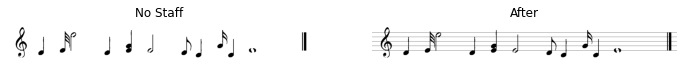

In [17]:
line_indices = get_line_indices(histogram(bin_img, 0.8))
print(line_indices)
generated_lines_img = np.copy(no_staff_img)
lines = []
for index in line_indices:
    line = ((0, index), (bin_img.shape[1]-1, index))
    lines.append(line)
    rr, cc, val = draw.line_aa(index, 0, index, bin_img.shape[1]-1)
    generated_lines_img[rr, cc] = 0

show_images([no_staff_img, generated_lines_img], ['No Staff', 'After'])

In [18]:
# h_lines = probabilistic_hough_line(255-gray, threshold=gray.shape[1]//2)
# lines = []
# h_lines = sorted(h_lines, key=lambda l : l[0][1])

# no_staff_lines = np.copy(no_staff_img)
# for index, line in enumerate(h_lines):
#     if index > 0 and (line[0][1] - lines[-1][0][1] < 0.9*spacing):
#         pass
#     else:
#         p1, p2 = line
#         x0, y0 = p1
#         x1, y1 = p2
#         lines.append(line)
#         rr, cc = draw.line(x0, y0, x1, y1)
#         # print(rr, cc)
#         no_staff_lines[cc, rr] = 0

# show_images([no_staff_img, no_staff_lines], ['No Staff', 'No Staff + Hough'])

In [19]:
end_of_staff = []
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - end_of_staff[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        end_of_staff.append((x0, y0, x1, y1))

In [20]:
box_centers = []
spacing_between_staff_blocks = []
for i in range(len(end_of_staff)-1):
    spacing_between_staff_blocks.append(end_of_staff[i+1][1] - end_of_staff[i][1])
    if i % 2 == 0:
        offset = (end_of_staff[i+1][1] - end_of_staff[i][1])//2
        center = end_of_staff[i][1] + offset
        box_centers.append((center, offset))

max_staff_dist = np.max(spacing_between_staff_blocks)
max_margin = max_staff_dist // 2
margin = max_staff_dist // 10

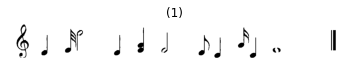

In [21]:
end_points = []
regions_of_interest = []
regions_with_staff = []
img_with_bboxes = np.copy(gray)
for index, (center, offset) in enumerate(box_centers):
    y0 = int(center) - max_margin - offset + margin
    y1 = int(center) + max_margin + offset - margin
    end_points.append((y0, y1))

    rr, cc = draw.rectangle(start = (y0, 0), end = (y1, img_with_bboxes.shape[1]), shape=img_with_bboxes.shape)
    # io.imsave(f'blocks/region{index}.png', gray[y0:y1, 0:img_with_bboxes.shape[1]])
    regions_with_staff.append(gray[y0:y1, 0:img_with_bboxes.shape[1]])
    staff_block = no_staff_img[y0:y1, 0:img_with_bboxes.shape[1]]
    show_images([staff_block])
    regions_of_interest.append(opening(staff_block, np.ones((thickness, thickness))))
    img_with_bboxes[rr, cc] = 0

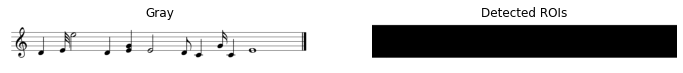

ROIs....


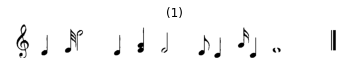

In [22]:
show_images([gray, img_with_bboxes], ['Gray', 'Detected ROIs'])
print('ROIs....')
if thickness % 2 == 0:
    thickness += 1
for staff_block in regions_of_interest:
    io.imsave('staff_test.png', staff_block.astype(np.uint8))
    show_images([staff_block])
    # print(np.max(staff_block))

In [23]:
def get_connected_components(bin_img):
    components = []
    thresh = threshold_otsu(bin_img)
    bw = closing(bin_img <= thresh, square(3))
    label_img = label(bw)
    img_label_overlay = label2rgb(label_img, image=bin_img, bg_label=0)
    for region in regionprops(label_img):
        if region.area >= 100:
            minr, minc, maxr, maxc = region.bbox
            components.append(img_with_staff[minr:maxr, minc:maxc])
    return components

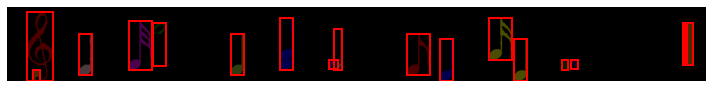

In [68]:
img = regions_of_interest[0]
img_with_staff = regions_with_staff[0]
primatives = []
thresh = threshold_otsu(img)
bw = closing(img <= thresh, square(3))
label_img = label(bw)
img_label_overlay = label2rgb(label_img, image=img, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_label_overlay)
for region in regionprops(label_img):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        primatives.append(img_with_staff[0:img.shape[0], minc:maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()

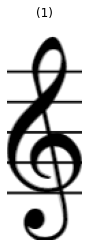

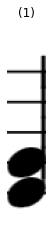

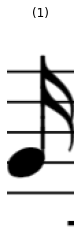

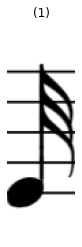

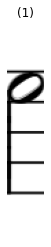

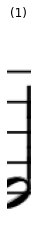

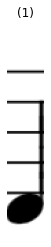

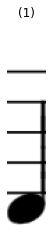

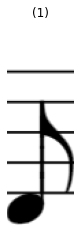

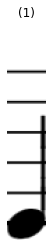

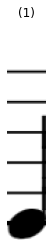

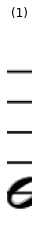

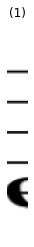

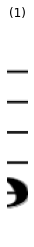

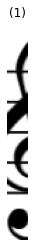

In [69]:
for i, prim in enumerate(primatives):
    prim = 255*prim
    # io.imsave(f'output/01/prim{i}.png', prim.astype(np.uint8))
    show_images([prim])

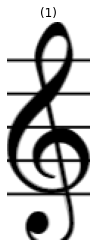

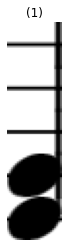

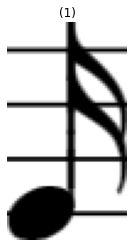

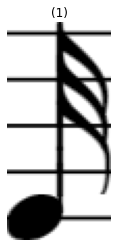

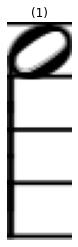

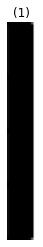

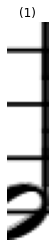

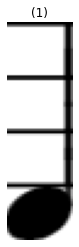

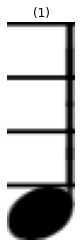

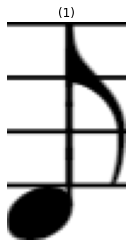

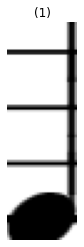

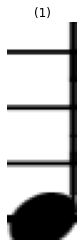

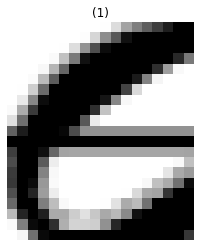

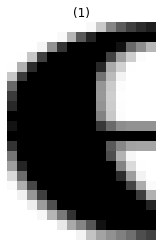

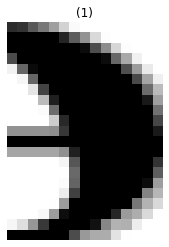

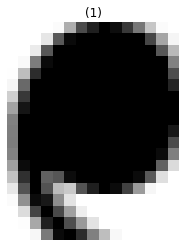

Done


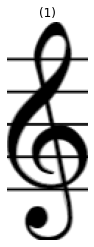

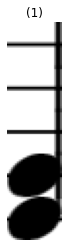

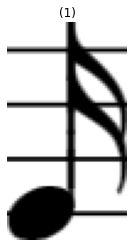

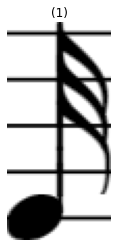

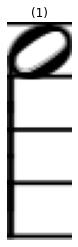

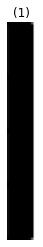

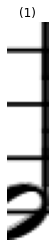

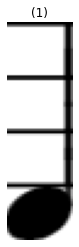

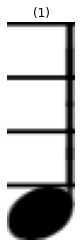

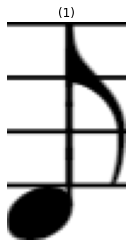

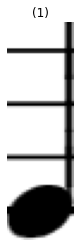

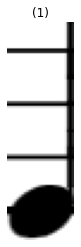

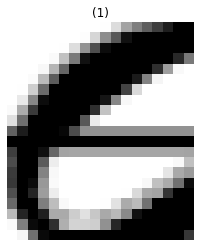

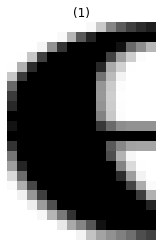

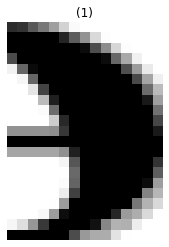

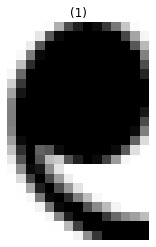

Done


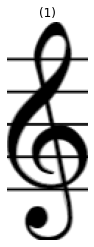

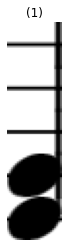

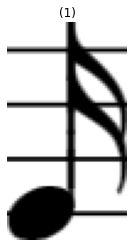

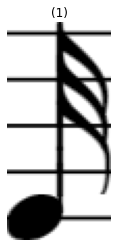

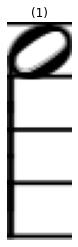

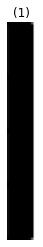

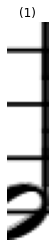

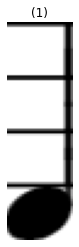

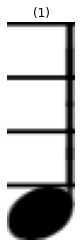

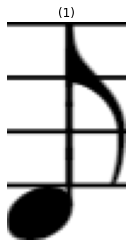

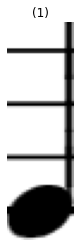

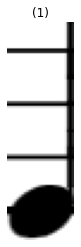

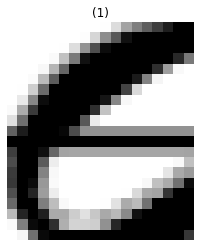

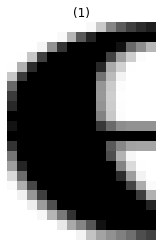

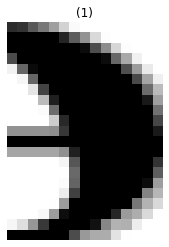

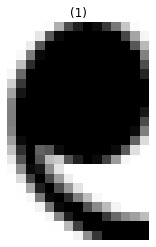

Done


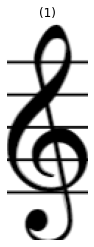

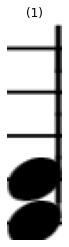

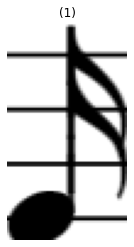

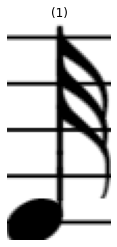

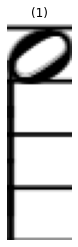

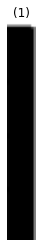

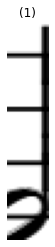

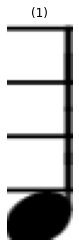

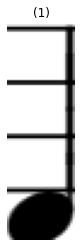

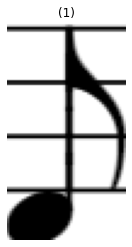

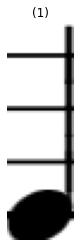

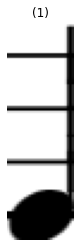

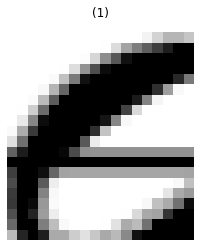

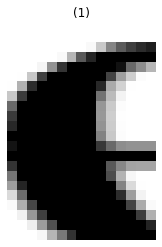

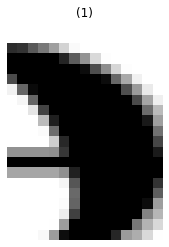

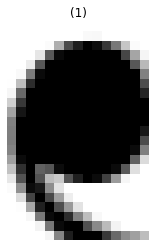

Done


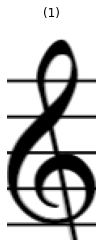

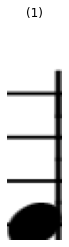

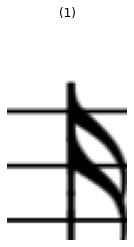

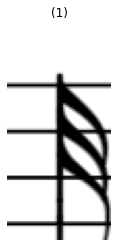

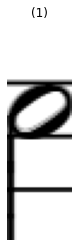

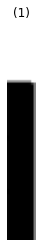

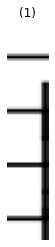

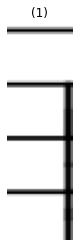

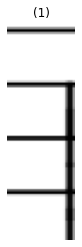

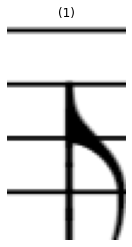

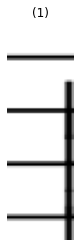

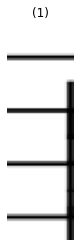

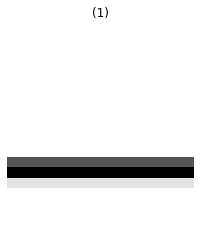

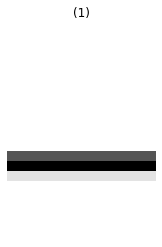

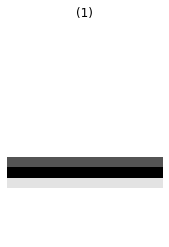

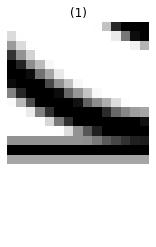

Done


In [65]:
same_h = []
for index in line_indices:
    comps = get_connected_components(img[max(0, index-5*thick_space):min(img.shape[0], index+5*thick_space), 0:img.shape[1]])
    for comp in comps:
        show_images([comp])
        same_h.append(comp)
    print("Done")

In [27]:
black = io.imread('heads/black.png')
black = get_gray(black)
black = get_thresholded(black, threshold_otsu(black))

half = io.imread('heads/half.png')
half = get_gray(half)
half = get_thresholded(half, threshold_otsu(half))

whole = io.imread('heads/whole.png')
whole = get_gray(whole)
whole = get_thresholded(whole, threshold_otsu(whole))

In [57]:
def detect_head(img, template, thresh):
    if img.shape[0] < template.shape[0] or img.shape[1] < template.shape[1]:
        img = sk_resize(img, template.shape)
    result = match_template(img, template)
    points = np.where(result >= thresh)
    h, w = template.shape
    return [[(pt[0], pt[1], w, h) for pt in zip(*points[::-1])]]

In [29]:
def calculate_overlap(a, b):
    overlap_x = max(0, min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0]))
    overlap_y = max(0, min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1]))
    overlap_area = overlap_x*overlap_y
    area = a[2]*a[3]
    return overlap_area/area
def merge2boxes(a, b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)
def merge_boxes(boxes, threshold):
    filtered_boxes = []
    while len(boxes) > 0:
        r = boxes.pop(0)
        boxes.sort(key=lambda box: np.sqrt( ((box[0]+box[2]/2) - (r[0]+r[2]/2))**2 + ((box[1]+box[3]/2) - (r[1]+r[3]/2))**2))
        merged = True
        while merged:
            merged = False
            i = 0
            for _ in range(len(boxes)):
                if calculate_overlap(r, boxes[i]) > threshold or calculate_overlap(boxes[i], r) > threshold:
                    r = merge2boxes(r, boxes.pop(i))
                    merged = True
                elif np.sqrt(((boxes[i][0]+boxes[i][2]/2) - (r[0]+r[2]/2))**2+((boxes[i][1]+boxes[i][3]/2) - (r[1]+r[3]/2))**2) > r[2]/2 + boxes[i][2]/2:
                    break
                else:
                    i += 1
        filtered_boxes.append(r)
    return filtered_boxes

In [71]:
def match_note_head(imgs, head):
    for img in imgs:
        heads = detect_head(img, head, 0.8)
        print([j for i in heads for j in i])
        bbox = merge_boxes([j for i in heads for j in i], 0.5)
        if len(bbox) == 1:
            print('Found :)')
            detected = np.copy(img)
            bbox = bbox[0]
            rr, cc = draw.rectangle_perimeter(start = (bbox[1], bbox[0]), end = (bbox[1]+bbox[3], bbox[0]+bbox[2]), shape=img.shape)
            rr = np.array(rr,dtype='int')
            cc = np.array(cc,dtype='int')
            detected[rr, cc] = 0
            center = bbox[1]+bbox[3]//2
            print(center)
            print(line_indices)
            print(min(line_indices, key=lambda x:abs(x-center)))
            show_images([img, detected], ['Original', 'Detected'])
        else:
            print('Not Found :(')

[]
Not Found :(
[(0, 118, 27, 18), (1, 118, 27, 18)]
Found :)
127
[46, 68, 90, 112, 135]
135


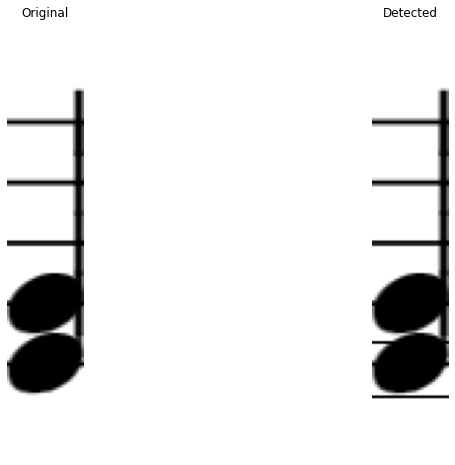

[(0, 96, 27, 18), (1, 96, 27, 18)]
Found :)
105
[46, 68, 90, 112, 135]
112


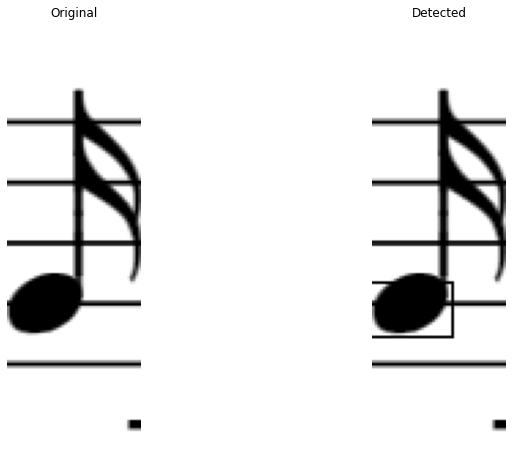

[(0, 118, 27, 18)]
Found :)
127
[46, 68, 90, 112, 135]
135


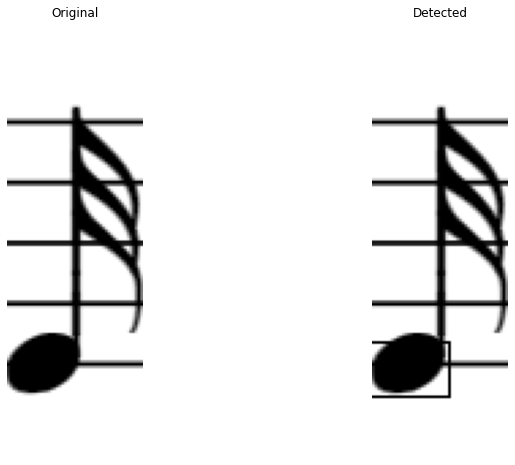

[]
Not Found :(
[]
Not Found :(
[]
Not Found :(
[]
Not Found :(
[(0, 130, 27, 18)]
Found :)
139
[46, 68, 90, 112, 135]
135


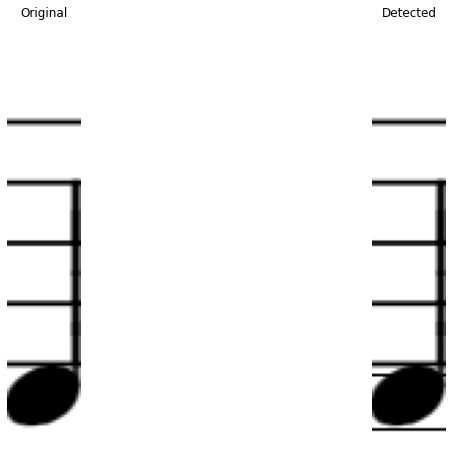

[(0, 130, 27, 18), (1, 130, 27, 18), (0, 131, 27, 18)]
Found :)
139
[46, 68, 90, 112, 135]
135


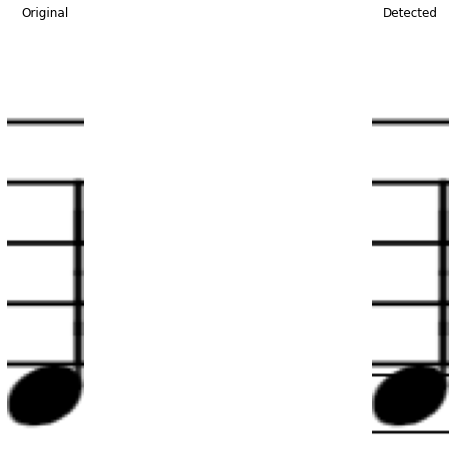

[(0, 130, 27, 18), (1, 130, 27, 18), (0, 131, 27, 18)]
Found :)
139
[46, 68, 90, 112, 135]
135


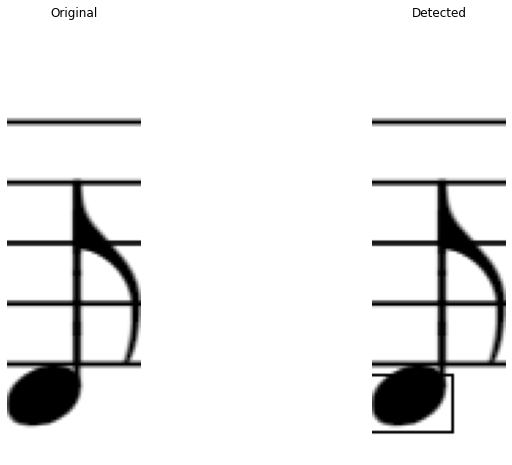

[(1, 141, 27, 18)]
Found :)
150
[46, 68, 90, 112, 135]
135


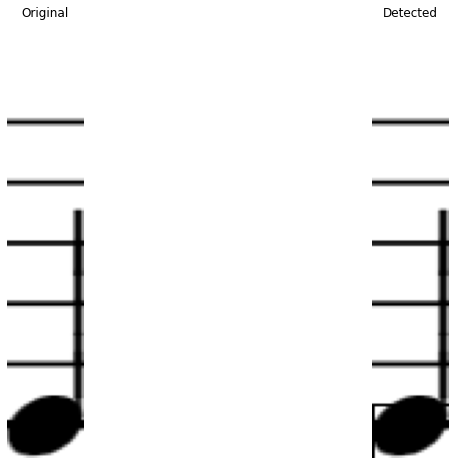

[(1, 141, 27, 18)]
Found :)
150
[46, 68, 90, 112, 135]
135


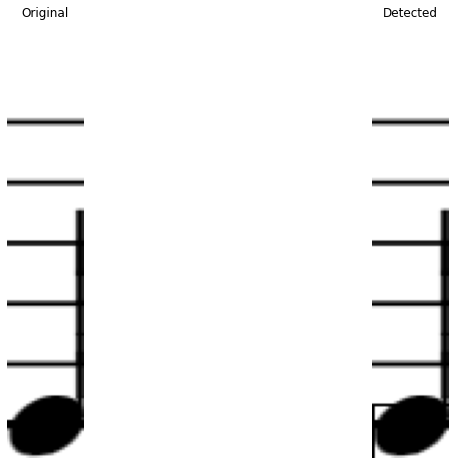

[]
Not Found :(
[]
Not Found :(
[]
Not Found :(
[]
Not Found :(


In [72]:
match_note_head(primatives, black)

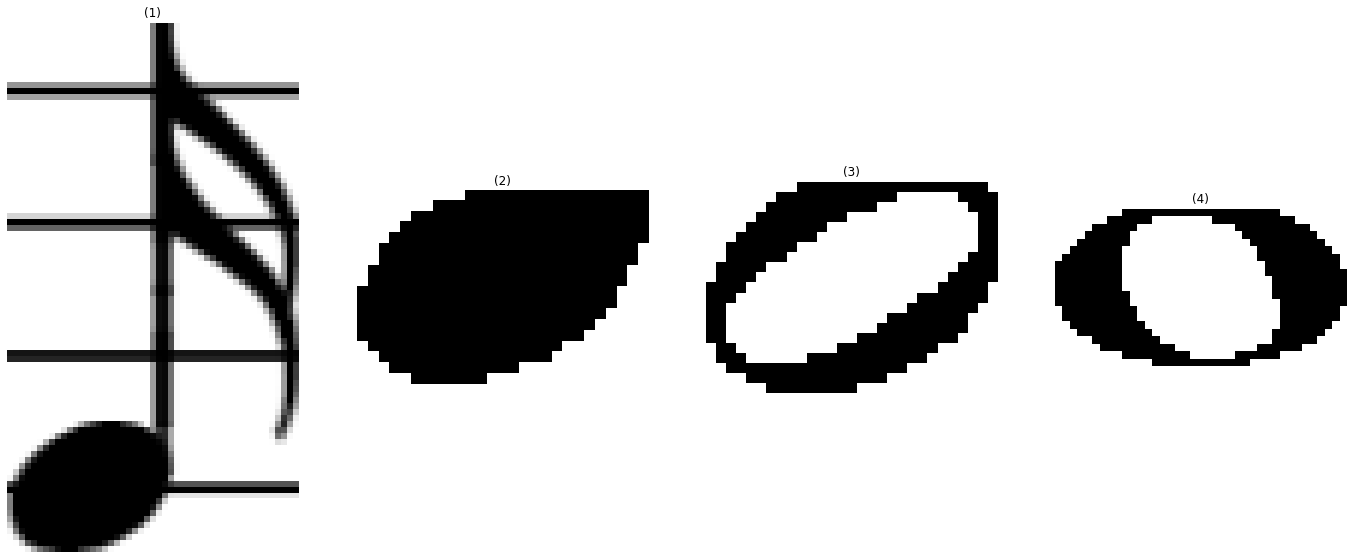

80
f
80
f


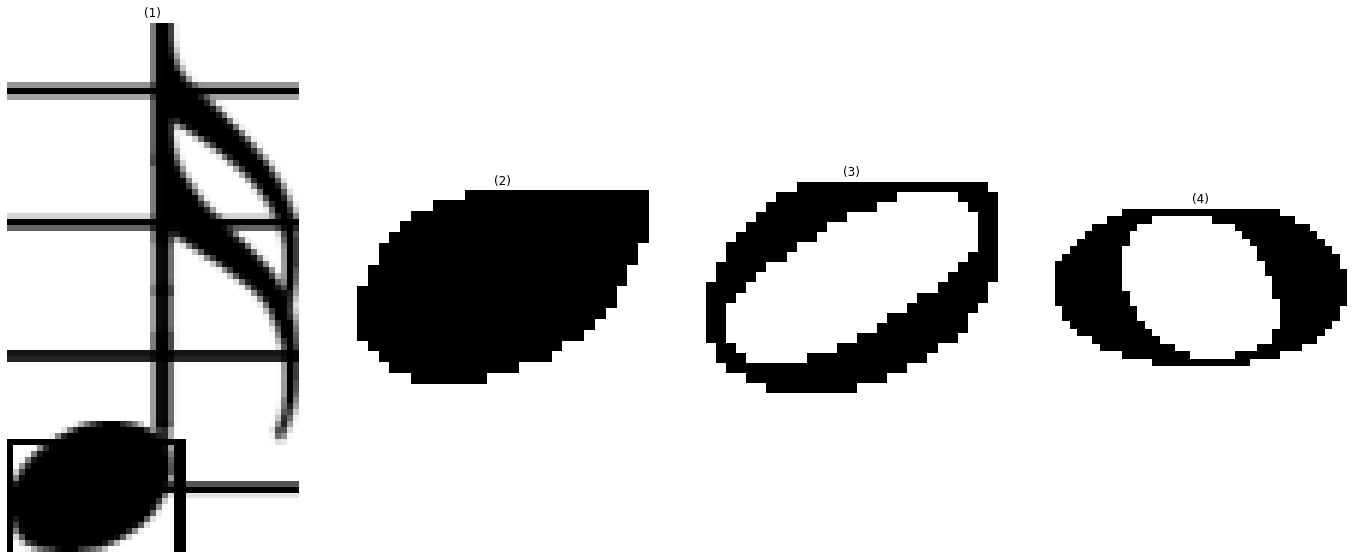

In [31]:
level = ['c', 'd', 'e', 'f', 'g', 'a', 'b']
test = np.copy(primatives[2])
show_images([test, black, half, whole])
template = np.copy(black)
result = match_template(test, template)
points = np.where(result >= 0.8)
h, w = template.shape
for pt in zip(*points[::-1]):
    rr, cc = draw.rectangle_perimeter((pt[1], pt[0]), (pt[1]+h, pt[0]+w), shape=test.shape)
    print(pt[1]+h//2)
    print(level[(pt[1]+h//2)%7])
    test[rr, cc] = 0
show_images([test, black, half, whole])

In [32]:
# lower, upper, samples, clef_thresh = 0.2, 1.0, 20, 0.7

# clef_imgs = {
#     "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
#     "bass": [io.imread('dataset/bass_1.jpg')],
#     "clef": [io.imread('clef8.jpg')]
# }

In [33]:
# '''
# An imutil function: https://github.com/jrosebr1/imutils/blob/master/imutils/convenience.py#L65
# '''
# def resize(image, width=None, height=None):
#     # initialize the dimensions of the image to be resized and
#     # grab the image size
#     dim = None
#     (h, w) = image.shape[:2]

#     # if both the width and height are None, then return the
#     # original image
#     if width is None and height is None:
#         return image

#     # check to see if the width is None
#     if width is None:
#         # calculate the ratio of the height and construct the
#         # dimensions
#         r = height / float(h)
#         dim = (int(w * r), height)

#     # otherwise, the height is None
#     else:
#         # calculate the ratio of the width and construct the
#         # dimensions
#         r = width / float(w)
#         dim = (width, int(h * r))

#     # resize the image
#     resized = sk_resize(image, dim)

#     # return the resized image
#     return resized

In [34]:
# def match(imgs, templates, start, stop, samples, thresh):
#     for img in imgs:
#         # template = canny(template, low_threshold=50, high_threshold=200)
#         for template in templates:
#             template = gray_img(template)
#             h, w = template.shape[:2]
#             gimg = gray_img(img)
#             found = None
#             for scale in np.linspace(start, stop, samples)[::-1]:
#                 resized = resize(template, width=int(template.shape[1]*scale))
#                 r = template.shape[1] / float(resized.shape[1])

#                 if np.any(np.less(gimg.shape, template.shape)):
#                     break

#                 # edged = canny(resized, low_threshold=50, high_threshold=100)
#                 result = match_template(gimg, resized)
#                 # result = np.where(result >= thresh)
#                 max_loc = np.unravel_index(np.argmax(np.copy(result)), result.shape)[::-1]
#                 # print(max_loc)
#                 max_val = result[max_loc[1], max_loc[0]]
#                 # print(max_val)
#                 if found is None or max_val > found[0]:
#                     found = (max_val, max_loc, r)
            
#             if found is not None:
#                 (_, max_loc, r) = found
#                 (minc, minr) = (int(max_loc[0]*r), int(max_loc[1]*r))
#                 (maxc, maxr) = (int((max_loc[0]+w)*r), int((max_loc[1]+h)*r))
#                 # print(minr, minc)
#                 # print(maxr, maxc)
#                 rr, cc = draw.rectangle(start=(minr, minc), end=(maxr, maxc), shape=img.shape)
#                 img[rr, cc] = 0
#                 # print(rr)
#                 # print(cc)
#                 show_images([template], ['Current Template'])
#                 show_images([img], ['Detected Image'])

In [35]:
# def match2(img,template,threshold):
#     template = gray_img(template)
#     result = match_template(img,template)
#     print(result)
#     return result > threshold

# prim = primatives[0]
# show_images([prim, skelon])
# for clef in clef_imgs:
#     for clef_img in clef_imgs[clef]:
#         clef_img = gray_img(clef_img)
#         if prim.shape != clef_img.shape:
#             prim = sk_resize(prim, clef_img.shape)
#         print('Trying....')
#         skelon = skeletonize(1-otsu(prim))
#         clef_img = skeletonize(1-otsu(clef_img))
#         show_images([skelon, clef_img])
#         found = match2(skelon,clef_img,0.5)
#         print('Finished Detection...\n')
#         if found:
#             print("Found 🙂")
#             show_images([clef_img], ['Detected Clef'])
#         else:
#             print("Not Found 🙁")

In [36]:

# for clef in clef_imgs:
#     match2(regions_with_staff, clef_imgs[clef], 0.2, 1.8, 50, 0.1)